# TABLE OF CONTENTS

* [1. INTRODUCTION](#section-one)
* [2. SETUP](#section-two)
    - [2.1 Install Yahoo Finance Package](#subsection-two-one)
    - [2.2 Import/Wrangle Data](#subsection-two-two)
    - [2.3 Inspect Data](#subsection-two-three)
* [3. SEARCHING RESPECTIVELY FOR THE PORTFOLIO WITH THE LOWEST VOLATILITY AND THE HIGHEST SHARPE](#section-three)
    - [3.1 Question 1: How do we simulate N sets of weights for the chosen securities?](#subsection-three-one)
    - [3.2 Question 2: How do we calculate the portfolio returns and volatilities?](#subsection-three-two)
    - [3.3 Question 3: How do we identify the highest Sharpe ratio portfolio and the minimum volatility portfolio?](#subsection-three-three)
* [4. (NEW) MARKOWITZ 1952 OPTIMAL WEIGHTS](#section-four)
    - [4.1 Question 4: How do we calculate the optimal weights analytically for the highest Sharpe ratio portfolio?](#subsection-four-one)
    - [4.2 Question 5: How do we calculate the optimal weights analytically for the lowest volatility portfolio?](#subsection-four-two)
    - [4.3 Question 6: How do calculate analytically the efficient frontier?](#subsection-four-three)
    - [4.4 Question 7: How does the analytically calculated efficient frontier compare to the simulated efficient frontier?](#subsection-four-four)
    - [4.5 Question 8: How do the risk-return profiles of the individual stocks compare to those of the efficient frontier, minimum volatility portfolio, and maximum Sharpe ratio portfolio?](#subsection-four-five)
* [5. CONCLUSION](#section-five)
* [6. REFERENCES](#section-six)

<a id="section-one"></a>
# 1. INTRODUCTION

## Objective

- Calculate optimal portfolio weights of selected Exchange Traded Funds (ETFs) using Monte Carlo simulation
- Plot the simulated efficient frontier 
- Analytically compute optimal portfolio weights 
- Plot the analytically computed efficient frontier

## Motivation

As a beginner investor, ETFs are a relatively secure way to diversify your investment portfolio across many stocks across various sectors and geographies. However, with there being over 7000 ETFs currently being traded in the market, which ETF do you choose? And how much should you invest in each ETF? Should you invest more in a security with higher returns or with lower volatility? From the perspective of a portfolio, while the portfolio return is the weighted-average of individual securities, the portfolio risk is not. A security's contribution to the portfolio risk comes from both its volatility and its correlation with other securities in the portfolio. As the number of securities in the portfolio increases (assuming that the securities' returns are not perfectly correlated), the contribution from the latter overwhelms that of the former. 

How do you to construct a portfolio with the lowest portfolio risk and the highest Sharpe ratio respectively? The key is in finding the optimal portfolio weights. In this notebook, we begin by stimulating N sets of weights for a set of chosen securities. Then, we back out two set of weights for the portfolios with the lowest portfolio risk and the highest Sharpe ratio, respectively.

Then, we analytically compute the optimal weights for a set of chosen securities for the lowest portfolio risk and the highest Sharpe ratio portfolio, respectively. We will also compare and contrast both the portfolios and the efficient frontiers derived from Monte Carlo simulation and computed from an optimization procedure, respectively. 



## Key Steps

Monte Carlo Simulation
1. Simulate N sets of weights for the chosen securities
2. Calculate the portfolio return, standard deviation, and Sharpe ratio for the N portfolios
3. Identify the portfolio that has the highest Sharpe ratio and the lowest volatility, respectively

Optimization Procedure
1. Analytically compute the optimal weights for both the highest Sharpe ratio and the lowest volatility portfolio, respectively
2. Analytically compute the set of efficient frontier

<a id="section-two"></a>
# 2. SETUP

<a id="subsection-two-one"></a>
## 2.1 Install Yahoo Finance API

In [1]:
!pip install yfinance

<a id="subsection-two-two"></a>
## 2.2 Import/Wrangle Data

In [2]:
import pandas as pd  
import numpy as np
import datetime as dt 
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco

# visual styles
plt.style.use('fivethirtyeight')
np.random.seed(1)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

See Other Visual Styles [HERE](https://matplotlib.org/3.2.1/gallery/style_sheets/style_sheets_reference.html)

In [3]:
symbols_list = ["BABA", "BILI", "BIDU"]
start = dt.datetime(2020,6,6)
end = dt.datetime(2021,3,12)
data = yf.download(symbols_list, start=start, end=end)

[*********************100%***********************]  3 of 3 completed


<a id="subsection-two-three"></a>
## 2.3 Inspect Data

In [4]:
data.head()

Adj Close                              Close              \
                  BABA        BIDU       BILI        BABA        BIDU   
Date                                                                    
2020-06-05  219.550003  114.400002  34.500000  219.550003  114.400002   
2020-06-08  219.000000  117.029999  34.959999  219.000000  117.029999   
2020-06-09  220.720001  115.830002  33.869999  220.720001  115.830002   
2020-06-10  223.679993  116.809998  35.480000  223.679993  116.809998   
2020-06-11  215.240005  111.830002  33.900002  215.240005  111.830002   

                             High                                Low  \
                 BILI        BABA        BIDU       BILI        BABA   
Date                                                                   
2020-06-05  34.500000  220.589996  115.199997  34.540001  218.699997   
2020-06-08  34.959999  220.399994  118.379997  35.700001  215.330002   
2020-06-09  33.869999  220.720001  116.760002  35.088001  216.199997   
2020-06-10  35.480000  225.000000  118.629997  35.790001  220.600006   
2020-06-11  33.900002  219.949997  114.080002  35.132000  213.559998   

                                         Open                         \
                  BIDU       BILI        BABA        BIDU       BILI   
Date                                                                   
2020-06-05  111.489998  33.110001  220.000000  111.860001  33.900002   
2020-06-08  115.629997  33.840000  219.600006  116.000000  34.680000   
2020-06-09  114.349998  33.790001  216.309998  115.389999  34.709999   
2020-06-10  115.919998  33.939999  222.000000  118.000000  34.119999   
2020-06-11  111.000000  33.584999  218.000000  112.629997  34.110001   

              Volume                    
                BABA     BIDU     BILI  
Date                                    
2020-06-05  11983200  4270200  5915000  
2020-06-08  12731200  4545200  5138300  
2020-06-09  14140100  2684200  3618300  
2020-06-10  13372400  3179200  4690900  
2020-06-11  15560300  4004800  4038800

Let's focus on the variable adjusted close

In [5]:
maindata = data["Adj Close"]
maindata.head()

,BABA,BIDU,BILI
Date,,,
2020-06-05,219.550003,114.400002,34.500000
2020-06-08,219.000000,117.029999,34.959999
2020-06-09,220.720001,115.830002,33.869999
2020-06-10,223.679993,116.809998,35.480000
2020-06-11,215.240005,111.830002,33.900002


In [6]:
maindata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 193 entries, 2020-06-05 to 2021-03-11
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BABA    193 non-null    float64
 1   BIDU    193 non-null    float64
 2   BILI    193 non-null    float64
dtypes: float64(3)
memory usage: 6.0 KB


Let's visualize the past price trends of the chosen securities.

Text(0, 0.5, 'price in $')

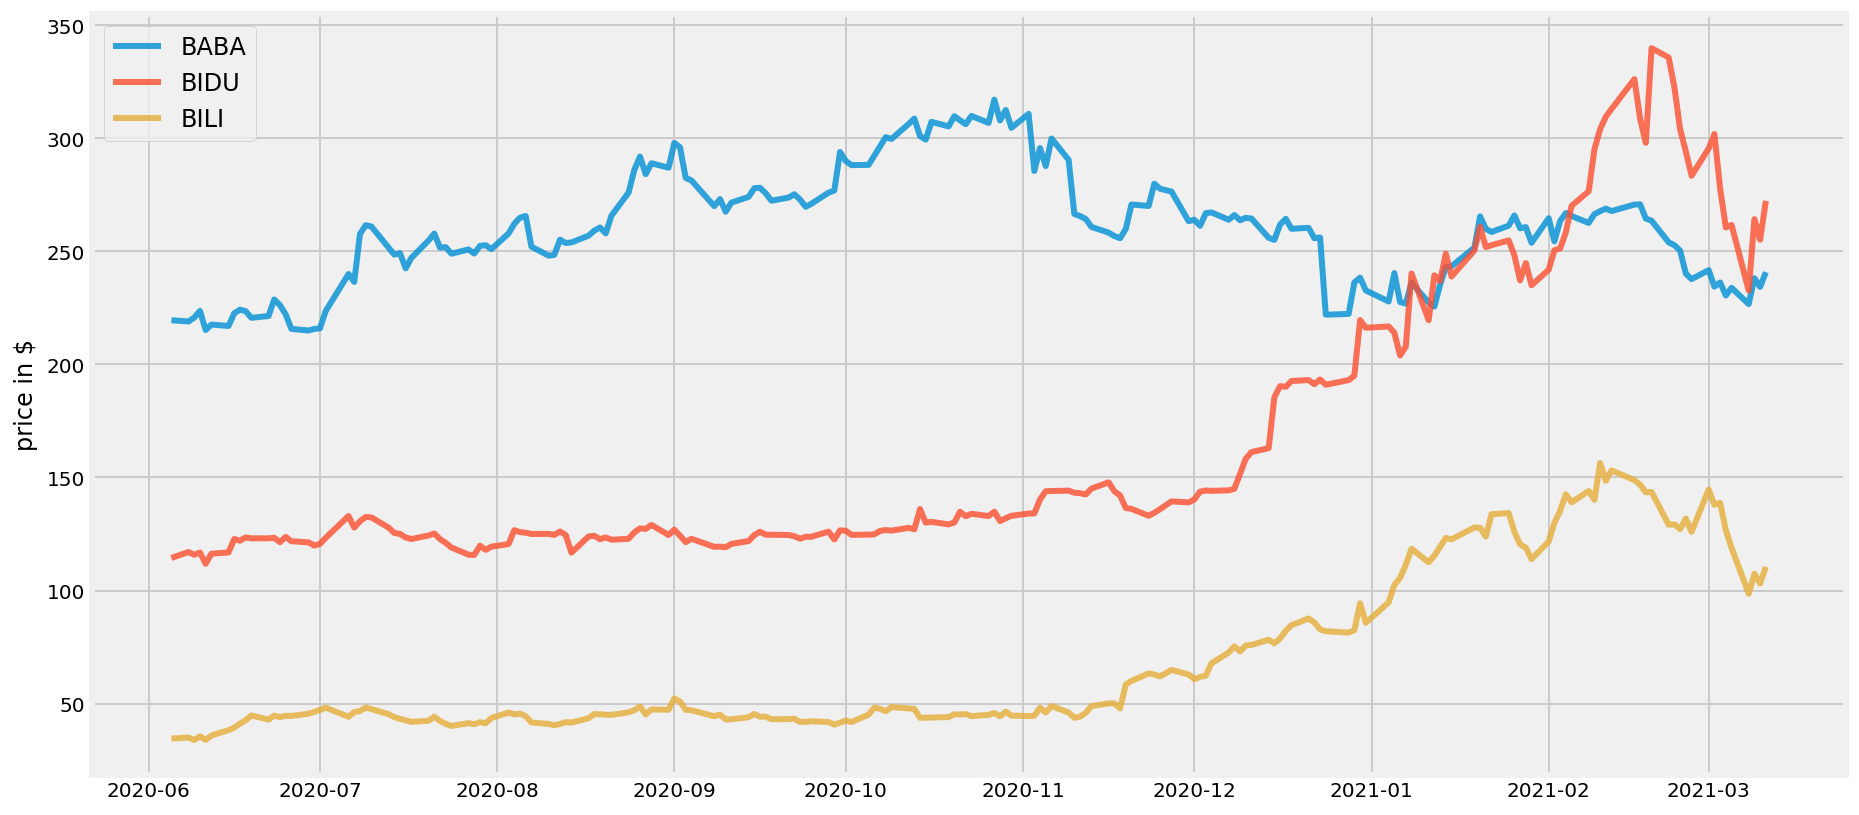

In [7]:
plt.figure(figsize=(14, 7))
for c in maindata.columns.values:
    plt.plot(maindata.index, maindata[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

In [8]:
maindata.head()

,BABA,BIDU,BILI
Date,,,
2020-06-05,219.550003,114.400002,34.500000
2020-06-08,219.000000,117.029999,34.959999
2020-06-09,220.720001,115.830002,33.869999
2020-06-10,223.679993,116.809998,35.480000
2020-06-11,215.240005,111.830002,33.900002


** What is going on with Facebook? It went public later on May 18, 2012.

Text(0, 0.5, 'daily returns')

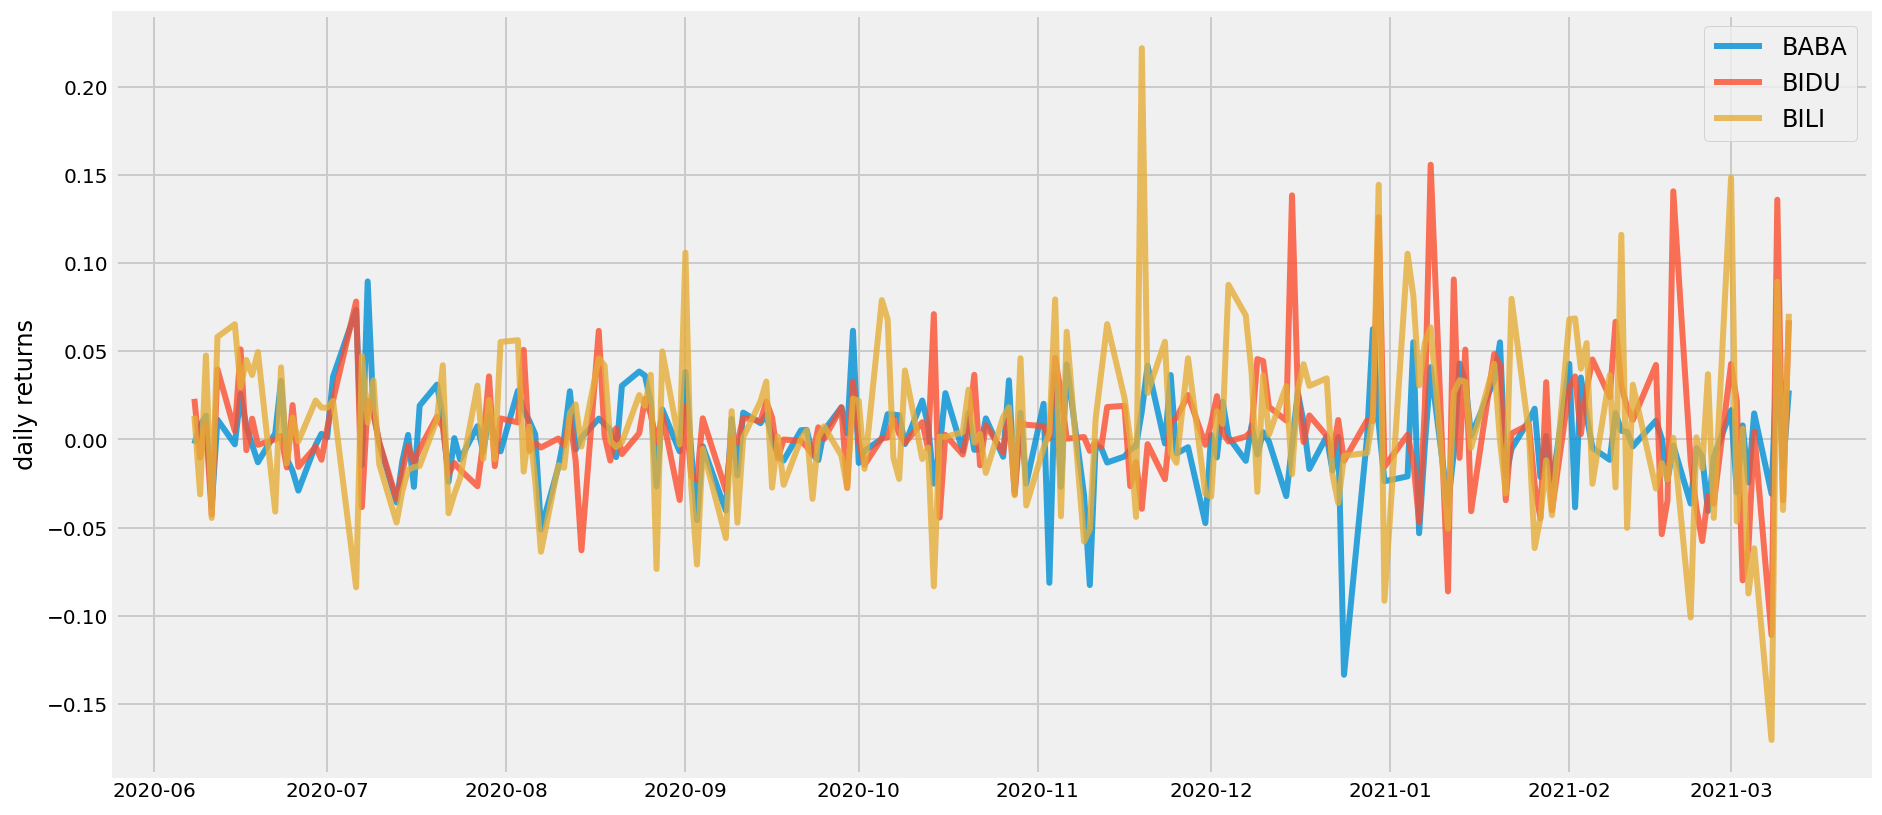

In [9]:
returns = maindata.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [10]:
returns

,BABA,BIDU,BILI
Date,,,
2020-06-05,NaN,NaN,NaN
2020-06-08,-0.002505,0.022989,0.013333
2020-06-09,0.007854,-0.010254,-0.031178
2020-06-10,0.013411,0.008461,0.047535
2020-06-11,-0.037732,-0.042633,-0.044532
...,...,...,...
2021-03-05,0.014707,0.004336,-0.061740
2021-03-08,-0.030784,-0.110958,-0.170397
2021-03-09,0.050509,0.135809,0.089360


** Why is return for the first observation NaN?  

<a id="section-three"></a>
# 3. SEARCHING RESPECTIVELY FOR THE PORTFOLIO WITH THE LOWEST VOLATILITY AND THE HIGHEST SHARPE

<a id="subsection-three-one"></a>
## 3.1 Question 1: How do we simulate N sets of weights for the chosen securities?

How should allocate our budget to each of securities in our portfolio. If our total budget is 1, the sum of the weights for the securities will be 1, such that the weights correspond to the portion of budget we allocate to a specific security. 

"random_portfolios" function will generate portfolios with random weights assigned to each stock. You can decide how many random portfolios you want to generate by passing num_portfolios argument. The num_securities argument indicates the number of securities in the portfolio (i.e., the number of elements in our stock list). This function generates and returns the random portfolio weights for all securities. It also returns a portfolio's annualised returns, annualised volatility, and Sharpe ratio (these parameters come from function portfolio_annualised_performance, which is discussed in the next section).

In [11]:
def random_portfolios(num_portfolios, num_securities, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        
        # Return random floats in the half-open interval [0.0, 1.0) 
        weights = np.random.random(num_securities)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

<a id="subsection-three-two"></a>
## 3.2 Question 2: How do we calculate the portfolio returns and volatilities?

"portfolio_annual_performance" function takes in three arguments: the weight for each security, average returns for each security, and covariance matrix of all securities in the portfolio. The function will then calculate the annualized portfolio returns and volatilities. Annualization assumes 252 trading days in one year.

In [12]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

Details on the calculation of portfolio standard deviation [HERE](https://stackoverflow.com/questions/59462628/is-there-a-way-to-vectorize-the-portfolio-standard-deviation-in-python-pandas)  
Details on dot product [HERE](https://towardsdatascience.com/linear-algebra-basics-dot-product-and-matrix-multiplication-2a7624942810).  


In [13]:
num_securities = len(symbols_list)
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000 # Simulate 30000 sets of weights
risk_free_rate = 0.0108 # The 10-year treasury rate 

<a id="subsection-three-three"></a>
## 3.3 Question 3: How do we identify the highest Sharpe ratio portfolio and the minimum volatility portfolio?

What does this function do? First, it generates random portfolio from function random_portfolios, which returns the results (portfolio returns, portfolio volatility, portfolio Sharpe ratio) and weights for the corresponding result. Then it locates the portfolio with the highest Sharpe ratio portfolio and displays the highest Sharpe ratio portfolio as a red star sign. It repeats the process for the lowest volatility portfolio and displays it as a green star on the plot. Finally, it also plots all the randomly generated portfolios with colour map applied to them based on the Sharpe ratio. The bluer, the higher Sharpe ratio.

The function also displays the portfolio weights for the chosen securities.

In [14]:
def display_simulated_ef_with_random(df, mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,num_securities, mean_returns, cov_matrix, risk_free_rate)
    
    # Identify the Maximum Sharpe portfolio
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=df.columns,columns=['allocation'])
    max_sharpe_allocation['allocation'] = [round(i*100,2)for i in max_sharpe_allocation['allocation']]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    # Identify the Minimum Variance Portfolio 
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=df.columns,columns=['allocation'])
    min_vol_allocation['allocation'] = [round(i*100,2)for i in min_vol_allocation['allocation']]
    min_vol_allocation = min_vol_allocation.T
    
    # Output the portfolio return and standard deviation of the Minimum Volatility Portfolio
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    # Output the portfolio return and standard deviation of the Maximum Sharpe Portfolio
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    
    # Plot anualized portfolio return vs annualized portfolio volatility
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    
    # Mark Maximum Sharpe portfolio
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    
    # Mark Minimum variance portfolio
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.6
Annualised Volatility: 0.39


             BABA  BIDU  BILI
allocation  67.27  25.9  6.83
--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 1.53
Annualised Volatility: 0.53


            BABA   BIDU   BILI
allocation  0.02  54.92  45.06


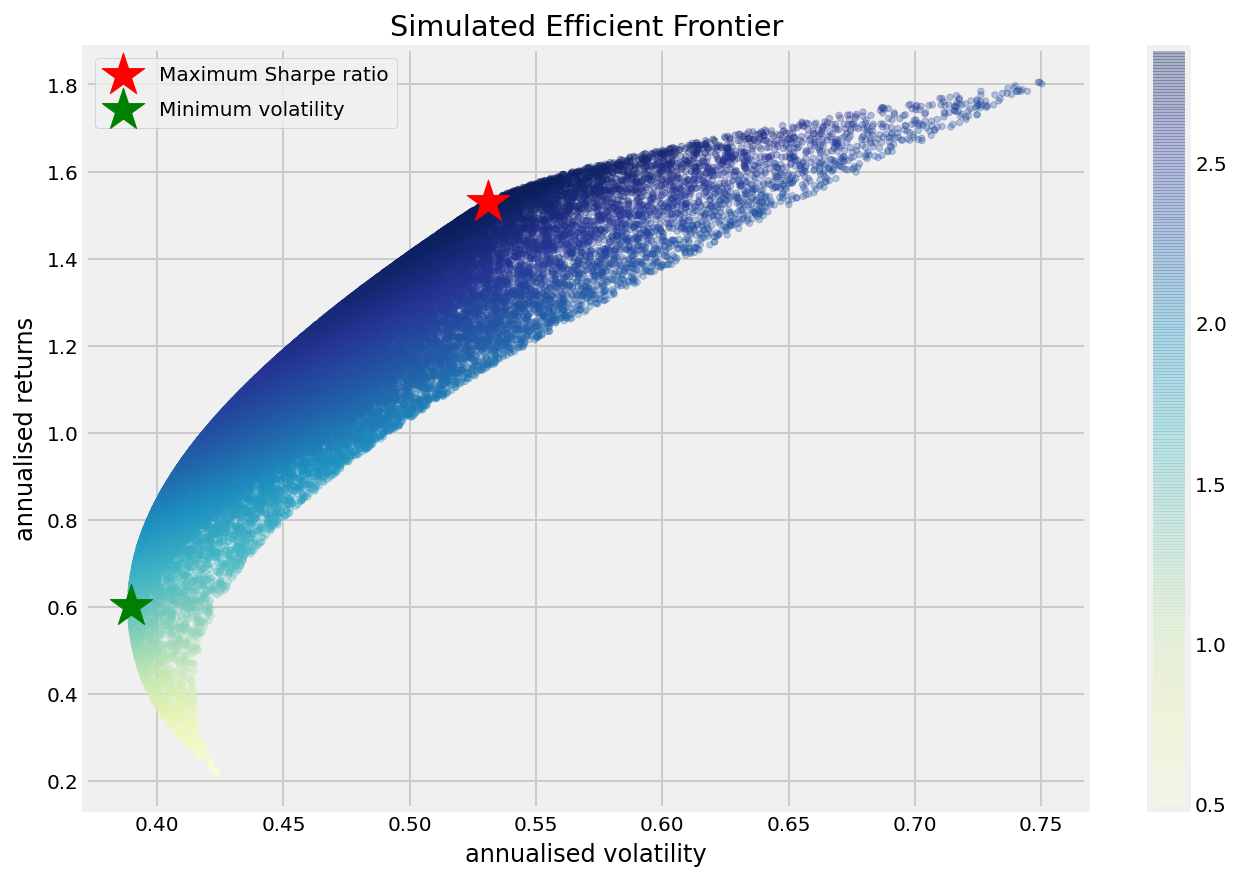

In [15]:
display_simulated_ef_with_random(returns, mean_returns, cov_matrix, num_portfolios, risk_free_rate)

<a id="subsection-four-one"></a>
## 4.1 Question 4: How do we calculate the optimal weights analytically for the highest Sharpe ratio portfolio?

The functions below are to get the maximum Sharpe ratio portfolio. In Scipy's optimize function, there's no 'maximize', so as an objective function you need to pass something that should be minimized. That is why the first "neg_sharpe_ratio" is computing the negative Sharpe ratio. Now we can use this as our objective function to minimize. In "max_sharpe_ratio" function, you first define arguments (this should not include the variables you would like to change for optimisation, in this case, "weights"). The minimize() function returns the optimal weights for each securities in a portfolio.

In the call to minimize(), you pass six arguments:


1. objective_function: The first positional argument must be the function that you are optimizing.

neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate)

2. The next argument is an initial guess for the values of the solution. 

Here you are passing an array of equal weights (1/N) with the length of the number of assets in the portfolio.

3. args: The next argument is a tuple of other arguments that are necessary to be passed into the objective function. 

minimize() will always pass the current value of the solution x into the objective function, so this argument serves as a place to collect any other input necessary. In this example, you need to pass prices to objective_function(), so that goes here.

4. method: Optimization method.

Choice of method is "SLSQP" or Sequential Least Squares Programming.

5. constraints: The next argument is a sequence of constraints on the problem. 

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

The above constraint is saying that sum of x should be equal to 1. You can think of the 'fun' part construction as '1' on the right side of equal sign has been moved to the left side of the equal sign.

'np.sum(x) == 1' has become 'np.sum(x)-1'

And what does this mean? It simply means that the sum of all the weights should be equal to 1. You cannot allocate more than 100% of your budget in total.

6. bounds: The last argument is the sequence of bounds on the solution variables that you generated earlier.

"bounds" is giving another limit to assign random weights, by saying any weight should be inclusively between 0 and 1. You cannot give minus budget allocation to a stock or more than 100% allocation to a stock. We generate tuple of (0.0, 1.0)s with the length of the number of assets in the portfolio.

In [16]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    
    # Recall portfolio_annualised_performance(weights, mean_returns, cov_matrix) returns portfolio standard deviation and portfolio return
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result

<a id="subsection-four-two"></a>
## 4.2 Question 5: How do we calculate the optimal weights analytically for the lowest volatility portfolio?

Let's define the optimizing function for calculating minimum volatility portfolio. This time we really do minimize the objective function. What do we want to minimize? We want to minimize volatility by trying different weights. "constraints" and "bounds" are same as below.

In [17]:
#use the function portfolio_annualised_performance to return standard deviation [0]
#if [1] is portfolio returns, [2] is sharpe ratio

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

<a id="subsection-four-three"></a>
## 4.3 Question 6: How do calculate analytically the efficient frontier?

Again, you can draw a line which depicts where the efficient portfolios should be for a given risk rate. This is THE "efficient frontier," which is analytically computed. You will create two additional functions to compute the efficient frontier. The first function "efficient_return" calculates the most efficient portfolio for a given target return, and the second function "efficient_frontier" will take a range of target returns and compute efficient portfolio for each return level.

constraints = {'type': 'eq', 'fun': lambda x: portfolio_return(x) - target}

The above constraint is saying that the portfolio return (portfolio constituents' returns weighted by x) should be equal to the target portfolio return. You can think of the 'fun' part construction as 'target' on the right side of equal sign has been moved to the left side of the equal sign.

'portfolio_return(x) == target' has become 'portfolio_return(x) - target'

In [18]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    # calculate the portfolio return given portfolio weights
    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    bounds = tuple((0,1) for asset in range(num_assets))
    
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

<a id="subsection-four-four"></a>
## 4.4 Question 7: How does the analytically calculated efficient frontier compare to the simulated efficient frontier?

Let's try to plot the portfolio choice with maximum Sharpe ratio and minimum volatility also with all the randomly generated portfolios. But this time we are not picking the optimal ones from the randomly generated portfolios, but we are actually calculating by using Scipy's 'minimize' function. And the below function will also plot the efficient frontier line.

In [19]:
def display_calculated_ef_with_random(df,mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,num_securities, mean_returns, cov_matrix, risk_free_rate)
    
    min_vol = min_variance(mean_returns, cov_matrix)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print (min_vol)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)    

    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print (max_sharpe)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation
    
    print ("-"*80)
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    
    # results[0,i] = portfolio_std_dev
    # results[1,i] = portfolio_return
    # results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    # np.linspace(start, stop, number of samples) returns evenly spaced samples, calculated over the interval [start, stop]
    target = np.linspace(rp_min, 0.32, 50)
    
    # function efficient_portfolios returns the results of Scipy's minimize function, which contains 'fun' the value of the optimized function
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [ ]:
display_calculated_ef_with_random(returns, mean_returns, cov_matrix, num_portfolios, risk_free_rate)

<a id="subsection-four-five"></a>
## 4.5 Question 8: How do the risk-return profiles of the individual stocks compare to those of the efficient frontier, minimum volatility portfolio, and maximum Sharpe ratio portfolio?

In [ ]:
def display_ef_with_selected(df, mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print(df.tail(10))
    print ("-"*80)
    print(df.info())
    an_vol = np.std(df) * np.sqrt(252)
    
    print ("-"*80)
    print(mean_returns)
    an_rt = mean_returns * 252
    
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(df.columns):
        print (txt,":","annualised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    # One security one dot
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    # Show security name right beside a dot
    for i, txt in enumerate(df.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
        
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

In [ ]:
display_ef_with_selected(returns, mean_returns, cov_matrix, risk_free_rate)

<a id="section-five"></a>
# 5. CONCLUSION

## Efficient Frontier, Minimum Volatility Portfolio, Maximum Sharpe Ratio Portfolio: Simulated and Analytically Computed

First you create a simulated efficient frontier and identify the minimum volatility portfolio and the maximum Sharpe portfolio from the frontier. Then, you calculated analytically the minimum volatility portfolio, the maximum Sharpe portfolio, and the efficient frontier. The efficient frontier, the minimum volatility portfolio, and the maximum Sharpe portfolio you get from the Monte Carlo simulation are very close to what you get analytically. Thanks to the Law of Large Number, Monte Carlo simulation gets you very close to the analytical solutions.

<a id="section-six"></a>
# 6. REFERENCES

Markowitz, H.M. (March 1952). "[Portfolio Selection](http://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.1952.tb01525.x/full)". The Journal of Finance. 7 (1): 77–91. 

This notebook is adapted from code written by [Ricky Kim](https://towardsdatascience.com/@rickykim78) and [Bernard Brenyah](https://medium.com/@bbrenyah). 